# World of Warcraft Weapon Data Mining

In this humble project we will attmpt to mine the weapon data of WOW. 

There are three major types of weapons, which are:

- One-handed (melee)
- Two-handed (melee)
- Ranged 

We will focus on two-handed and ranged weapons, as my class in WOW is warrior with the Arms Talent. I am only Lv26 currently, and am struggling with leveling up! I would like to investigate the best weapon at each level for arms warrior.

An arms warrior favors one attribute, which is, the Damage Per Hit (DPH). The larger the DPH of a weapon, the better it is for me. Therefore, this project aims to figure out the ranks of two-handed weapons per level, under the measure of DPH, as well as the ranks of ranged weapons per level, under the measure of bonus DPS.

Let's get to start.

First of all, we have to import all the necessary libraries, and set them with some good parameters.

In [1]:
# Basic Libraries
# %pylab inline  # Keep the plot inline
import numpy as np  # For scientific computation
import pandas as pd # For dataframe operation
import matplotlib.pyplot as plt # For visualization
import seaborn as sb # For visualization
from sklearn.linear_model import RANSACRegressor, LinearRegression # For fitting the linear model

sb.set() # set the default Seaborn style for graphics
pd.set_option('display.max_columns', None) # Disable the limits on the preview
pd.set_option('display.max_rows', None)
sb.set(font_scale = 1.3) # Large font is friendly to your eye

### Data Cleaning

We have two csv files to deal with, all_weapon.csv and all_weapon_supp.csv. We start by previewing the first file, and amend some of the column name to a better shape.

In [2]:
rawData1 = pd.read_excel('all_weapon.xls')
rawData1.head()
rawData1.rename(columns={'|': 'itemid', '|__name_enus': 'name',  
                        '|__quality': 'quality', '|__icon': 'icon', 
                        '|__screenshot': 'screenshot', '|__jsonequip__cooldown': 'cooldown', 
                        '|__jsonequip__arcres': 'arcres', '|__jsonequip__armor': 'armor', 
                        '|__jsonequip__agi': 'agi', '|__jsonequip__atkpwr': 'atkpwr', 
                        '|__jsonequip__avgbuyout': 'avgbuyout', '|__jsonequip__buyprice': 'buyprice', 
                        '|__jsonequip__def': 'def', '|__jsonequip__classes': 'classes', 
                        '|__jsonequip__displayid': 'displayid', '|__jsonequip__dmgmax1': 'dmgmax1', 
                        '|__jsonequip__dmgmin1': 'dmgmin1', '|__jsonequip__dmgrange': 'dmgrange', 
                        '|__jsonequip__dmgtype1': 'dmgtype1', '|__jsonequip__dps': 'dps', 
                        '|__jsonequip__dura': 'dura', '|__jsonequip__manargn': 'manargn', 
                        '|__jsonequip__healthrgn': 'healthrgn', '|__jsonequip__int': 'int', 
                        '|__jsonequip__firres': 'firres', '|__jsonequip__frores': 'frores', 
                        '|__jsonequip__holsplpwr': 'holsplpwr', '|__jsonequip__maxcount': 'maxcount',
                        '|__jsonequip__mlecritstrkpct': 'mlecritstrkpct', '|__jsonequip__mledmgmax': 'mledmgmax',
                        '|__jsonequip__mledmgmin': 'mledmgmin', '|__jsonequip__mledps': 'mledps',
                        '|__jsonequip__mlehitpct': 'mlehitpct', '|__jsonequip__mlespeed': 'mlespeed',
                        '|__jsonequip__races': 'races', '|__jsonequip__reqskill': 'reqskill',
                        '|__jsonequip__reqskillrank': 'reqskillrank', '|__jsonequip__natres': 'natres',
                        '|__jsonequip__parrypct': 'parrypct', '|__jsonequip__reqlevel': 'reqlevel',
                        '|__jsonequip__rgdcritstrkpct': 'rgdcritstrkpct', '|__jsonequip__rgdhitpct': 'rgdhitpct',
                        '|__jsonequip__sellprice': 'sellprice', '|__jsonequip__shares': 'shares',
                        '|__jsonequip__sheathtype': 'sheathtype', 
                        '|__jsonequip__slotbak': 'slotbak', '|__jsonequip__speed': 'speed', 
                        '|__jsonequip__splcritstrkpct': 'splcritstrkpct', '|__jsonequip__splpwr': 'splpwr', 
                        '|__jsonequip__spi': 'spi', '|__jsonequip__splheal': 'splheal', 
                        '|__jsonequip__sta': 'sta', '|__jsonequip__str': 'str', 
                        '|__attainable': 'attainable', '|__flags2': 'flags2',
                         '|__jsonequip__arcsplpwr': 'arcsplpwr', '|__jsonequip__feratkpwr': 'feratkpwr',
                         '|__jsonequip__firsplpwr': 'firsplpwr', '|__jsonequip__itemset': 'itemset',
                         '|__jsonequip__frosplpwr': 'frosplpwr', '|__jsonequip__natsplpwr': 'natsplpwr',
                         '|__jsonequip__reqfaction': 'reqfaction', '|__jsonequip__shasplpwr': 'shasplpwr',
                         '|__jsonequip__splpen': 'splpen', '|__jsonequip__splhitpct':'splhitpct', 
                       }, inplace=True)

In [3]:
rawData2 = pd.read_excel('all_weapon_supp.xls')

We then combine the two dataframe. All the rest analysis will be base on weaponData.

In [4]:
# We only select meaningful column from the raw dataframe.
weaponData1 = pd.DataFrame(rawData1[['name', 'quality', 'dps', 'speed', 'rgdcritstrkpct',
                                     'rgdhitpct', 'atkpwr', 'str', 'agi']])
weaponData1.head()

weaponData2 = pd.DataFrame(rawData2[['level', 'reqclass', 'reqlevel', 'subclass', 'contentPhase']])
weaponData2.head()
# 'level', 'reqclass', 'reqlevel'

# Combine the two dataframe.
weaponData = weaponData1.join(weaponData2)
weaponData.rename(columns={'rgdcritstrkpct':'critstrkpct', 'rgdhitpct':'hitpct', 'subclass':'type'}, inplace=True)

Lets overview the data. We find that there are 1765 weapons included. Lots of entries are Not a Number (NaN). 
We must solve this problem.

In [5]:
weaponData.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765 entries, 0 to 1764
Data columns (total 14 columns):
name            1765 non-null object
quality         1765 non-null int64
dps             1764 non-null float64
speed           1764 non-null float64
critstrkpct     75 non-null float64
hitpct          27 non-null float64
atkpwr          87 non-null float64
str             287 non-null float64
agi             187 non-null float64
level           1765 non-null int64
reqclass        57 non-null float64
reqlevel        1667 non-null float64
type            1765 non-null int64
contentPhase    1750 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 193.2+ KB


In [6]:
weaponData = weaponData.fillna(0) # Fill all the NaN by 0
weaponData.head()   # Now it looks good

,name,quality,dps,speed,critstrkpct,hitpct,atkpwr,str,agi,level,reqclass,reqlevel,type,contentPhase
0,Blade of Eternal Darkness,4,34.33,1.5,0.0,0.0,0.0,0.0,0.0,54,0.0,49.0,15,1.0
1,Shadow Hunter Knife,1,15.59,1.7,0.0,0.0,0.0,0.0,0.0,32,0.0,27.0,15,1.0
2,Gut Ripper,4,33.89,1.8,0.0,0.0,0.0,0.0,0.0,45,0.0,40.0,15,1.0
3,Witchblade,3,40.63,1.6,0.0,0.0,0.0,0.0,0.0,62,0.0,57.0,15,1.0
4,Hypnotic Blade,3,26.79,1.4,0.0,0.0,0.0,0.0,0.0,39,0.0,34.0,15,1.0


In [7]:
weaponData[['reqclass','reqlevel']] = weaponData[['reqclass','reqlevel']].astype(int) # Set some columns to integer
weaponData.head() # Now it looks even better

,name,quality,dps,speed,critstrkpct,hitpct,atkpwr,str,agi,level,reqclass,reqlevel,type,contentPhase
0,Blade of Eternal Darkness,4,34.33,1.5,0.0,0.0,0.0,0.0,0.0,54,0,49,15,1.0
1,Shadow Hunter Knife,1,15.59,1.7,0.0,0.0,0.0,0.0,0.0,32,0,27,15,1.0
2,Gut Ripper,4,33.89,1.8,0.0,0.0,0.0,0.0,0.0,45,0,40,15,1.0
3,Witchblade,3,40.63,1.6,0.0,0.0,0.0,0.0,0.0,62,0,57,15,1.0
4,Hypnotic Blade,3,26.79,1.4,0.0,0.0,0.0,0.0,0.0,39,0,34,15,1.0


In order to conveniently show the legend for future plotting, we create a new column to store the type name of each weapon.

In [8]:
weaponData['typename'] = weaponData['type'].map(
    {1:'Two-handed Axe',
     5:'Two-handed Mace',
     6:'Polearm',
     8:'Two-handed Sword',
     15:'Dagger',
     13:'Fist Weapon',
     0: 'One-handed Axe',
     4: 'One-handed Mace',
     7: 'One-handed Swords',
     10: 'Stave',
     2: 'Bow',
     18: 'Crossbow',
     3: 'Gun',
     16: 'Thrown',
     19: 'Wand',
     20: 'Fishing Pole',
     14: 'Miscellaneous'
     })

DPH is calculated by speed times dps. We calculate it and insert to the dataframe.

In [9]:
dph = weaponData.speed * weaponData.dps
weaponData.insert(loc=8, column='dph', value=dph)
weaponData.head()

,name,quality,dps,speed,critstrkpct,hitpct,atkpwr,str,dph,agi,level,reqclass,reqlevel,type,contentPhase,typename
0,Blade of Eternal Darkness,4,34.33,1.5,0.0,0.0,0.0,0.0,51.495,0.0,54,0,49,15,1.0,Dagger
1,Shadow Hunter Knife,1,15.59,1.7,0.0,0.0,0.0,0.0,26.503,0.0,32,0,27,15,1.0,Dagger
2,Gut Ripper,4,33.89,1.8,0.0,0.0,0.0,0.0,61.002,0.0,45,0,40,15,1.0,Dagger
3,Witchblade,3,40.63,1.6,0.0,0.0,0.0,0.0,65.008,0.0,62,0,57,15,1.0,Dagger
4,Hypnotic Blade,3,26.79,1.4,0.0,0.0,0.0,0.0,37.506,0.0,39,0,34,15,1.0,Dagger


Some of the weapons have no reqlevel (required character level), and have been filled to 0 by previous operation. This may produce an very large dps or dph at reqlevel = 0. Therefore, we have to carefully assign the reqlevel attribute according to some prior knowledge, which are:

- if the level attribute is less than or equal to 5, then we set them to 1;
- if the level attribute is greater than or equal to 66, then we set them to 60;
- otherwise set them to level - 5.

In [10]:
weaponData = weaponData.drop(weaponData[weaponData['reqclass']>1].index)
weaponData = weaponData.query('type== ["1", "5", "6", "8", "10", "2", "18", "3", "20"]')
for index, row in weaponData.iterrows():
    if row['reqlevel'] == 0:
        if row['level'] <= 5:
            weaponData.at[index,'reqlevel'] = 1
        elif row['level'] >= 66:
            weaponData.at[index,'reqlevel'] = 60
        else:
            tmp = row['level'] - 5
            weaponData.at[index,'reqlevel'] = tmp
                       
        

We have done the data cleaning. Hopefully our dataframe is in a good shape now.

### Exploratory Data Analysis
We start the EDA at our dataframe.

First, we would like to know the count and speed distribution for all the selected weapons including:

- two-handed weapons;
- ranged weapons.


Number of Types : 9
Stave               176
Two-handed Mace     128
Two-handed Sword    126
Two-handed Axe      119
Bow                 103
Gun                  85
Polearm              44
Crossbow             19
Fishing Pole          7
Name: typename, dtype: int64


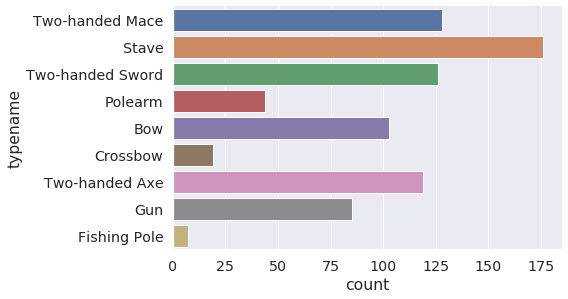

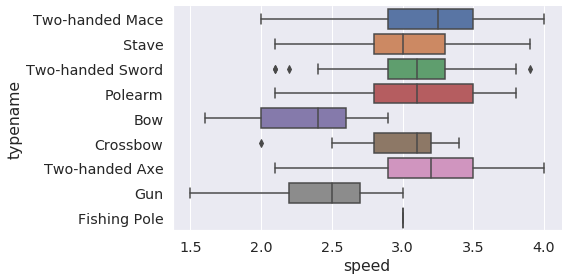

In [11]:
# Types in the Dataset
print("Number of Types :", len(weaponData["type"].unique()))

# Two-handed weapons in each type
print(weaponData["typename"].value_counts())
sb.catplot(y = "typename", data = weaponData, kind = "count", height=4, aspect=2)
sb.catplot(x = "speed", y = "typename", data = weaponData, kind = "box", height=4, aspect=2)

Next, we would like to know the reqlevel to dps and reqlevel to dph relationships.

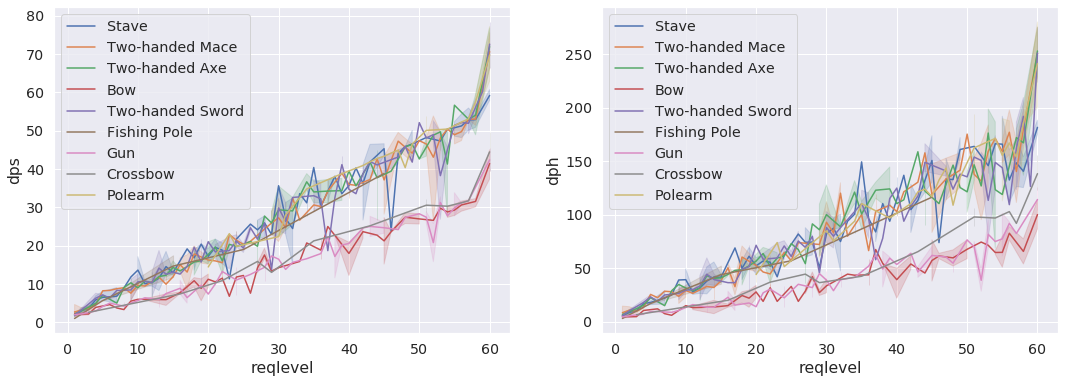

In [12]:
weaponDataByLevel = weaponData.sort_values('reqlevel')

fig, axis = plt.subplots(1, 2, figsize=(18, 6))
uniqueVals = weaponDataByLevel["typename"].unique()
types = [weaponDataByLevel[weaponDataByLevel["typename"]== val] for val in uniqueVals]

for i, t in enumerate(['dps', 'dph']):
    for idx, weaponType in enumerate(types):
        sb.lineplot(x=weaponType['reqlevel'], y=weaponType[t], data=weaponType, 
                    ax=axis[i % 2], label=uniqueVals[idx])


For the reqlevel to dps and reqlevel to dph relationships, they are all saw-like. And the ranged weapons are obviously lower than the melee couterparts.

It is not a good idea to do the fitting on this stage. We choice to filter the data by weapon quality.

There are six quality degree in WOW, which are:

- 0: poor
- 1: common
- 2: uncommon
- 3: rare
- 4: epic
- 5: legendary

A humble warrior like me may be a lone wolf, but a wapon at rare quality can still be a reasonable goal. Also, everyone should have a dream, right? Therefore, we only consider rare and epic weapons.

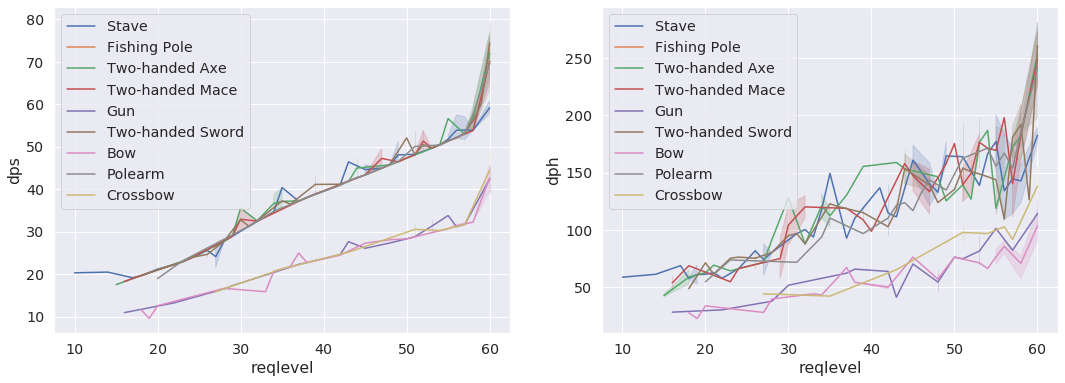

In [13]:
rareWeaponData = weaponData.query('quality== ["3", "4"]')
rareWeaponDataByLevel = rareWeaponData.sort_values('reqlevel')

fig, axis = plt.subplots(1, 2, figsize=(18, 6))
uniqueVals = rareWeaponDataByLevel["typename"].unique()
types = [rareWeaponDataByLevel[rareWeaponDataByLevel["typename"]== val] for val in uniqueVals]

for i, t in enumerate(['dps', 'dph']):
    for idx, weaponType in enumerate(types):
        sb.lineplot(x=weaponType['reqlevel'], y=weaponType[t], data=weaponType, 
                    ax=axis[i % 2], label=uniqueVals[idx],alpha=1)

After filtering the data, we have a very nice reqlevel to dps relationship, and a even worse reqlevel to dph one. This is reasonable. According to the prior knowledge from Blizzard, who designed WOW, the dps and character level are always in a linear relationship, which is now shown as lines in the left figure above. However, the speed of weapon may greatly varied, thats why the two figures above are in such sharp contrast.

We choose to fit dps to reqlevel, and use the coefficient to extrapolate the dph-reqlevel relationship.

We use common least square regression and Random Sampling Consensus [(RANSAC)](https://en.wikipedia.org/wiki/Random_sample_consensus) to fit the data, and choose the better one for determining the extrapolation.

It should be noted that we care only the melee weapons for the DPH extracpolation. For the ranged weapons, a warrior will not use it to deal damage, but only equip one for attribution bonus. 

We therefore firstly deal with the melee weapons as a linear regression problem.

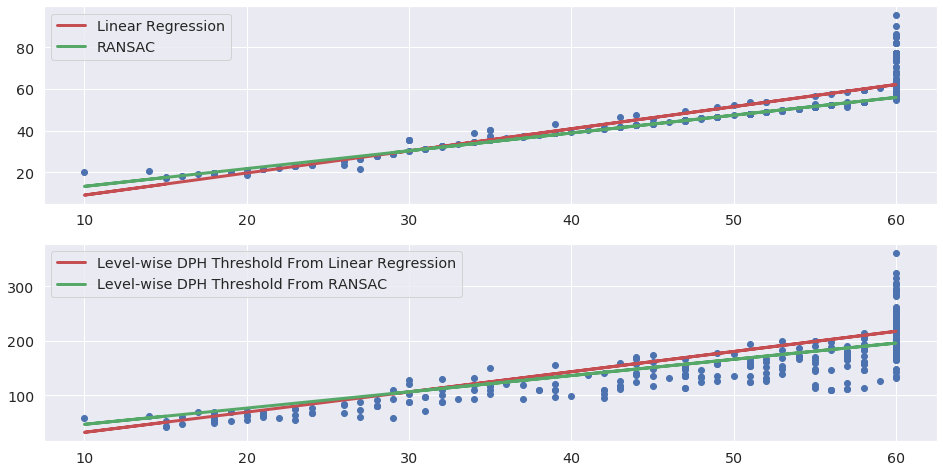

In [14]:
f, axes = plt.subplots(2, 1, figsize=(16, 8))

meleeWeaponData = rareWeaponData.query('type== ["1", "5", "6", "8", "10", "20"]')
X = meleeWeaponData[['reqlevel']]
linreg = LinearRegression()
ranreg = RANSACRegressor(LinearRegression(), max_trials = 1000, stop_probability = 0.9999, residual_threshold=1)
baseSpeed = 3.5


Y = meleeWeaponData[['dps']]
linreg.fit(X, Y)
ranreg.fit(X, Y)

reglineX = X
reglineY = linreg.intercept_ + linreg.coef_ * X
reglineYRansac = ranreg.estimator_.intercept_ + ranreg.estimator_.coef_ * X

axes[0].scatter(X, Y)
axes[0].plot(reglineX, reglineY, 'r-', linewidth = 3)
axes[0].plot(reglineX, reglineYRansac, 'g-', linewidth = 3)
axes[0].legend(['Linear Regression', 'RANSAC'], loc="best")

reglinePredFromRegDps = baseSpeed * reglineY
reglinePredFromRansacDps = baseSpeed * reglineYRansac


Y = meleeWeaponData[['dph']]
axes[1].scatter(X, Y)
axes[1].plot(reglineX, reglinePredFromRegDps, 'r-', linewidth = 3)  
axes[1].plot(reglineX, reglinePredFromRansacDps, 'g-', linewidth = 3)  
axes[1].legend(['Level-wise DPH Threshold From Linear Regression', 
                'Level-wise DPH Threshold From RANSAC'], loc="best")


For upper figure, We see that the least square regression (red line) is skewed by the data points from lvel 60, which refere to the powerful weapons with extremely powerful DPS. In contrast, RANSAC (green line) perfectly capture the linear relationship without being skewed.

For lower figure, the two lines are drawn using the parameters from dps. The skew of red line is even more terrible, whereas the green line produces reasonable result. I say it is reasonable because for reqlevel = 51, the highest data point corresponds to the Ice Barbed Spear, a very nice weapon which can be acquired at level 51 yet has nearly the same dpsa at level 60. Accordingly, when reqlevel = 60, the highest data point at reqlevel = 51 has almost the same height with the green line.

Nest we will calculate the level superior for each weapon. Good weapons will have positive number, while bad weapons will have negative number.

We only consider those with positive level superior. We also exclude the weapons at reqlevel 60, which suit players riching in time or money.

In [15]:
keys = list(range(1,61))
valuesDPS = (ranreg.estimator_.intercept_ + ranreg.estimator_.coef_[0] * keys)
valuesDPH = (ranreg.estimator_.intercept_ + ranreg.estimator_.coef_[0] * keys) * baseSpeed
BenchmarkDPS = dict(zip(keys, valuesDPS))
BenchmarkDPH = dict(zip(keys, valuesDPH))


meleeWeaponData.loc[:,'baseDPH'] = meleeWeaponData.loc[:,'reqlevel'].map(BenchmarkDPH)
meleeWeaponData.loc[:, 'diffDPH'] = meleeWeaponData.loc[:, 'dph'] - meleeWeaponData.loc[:,'baseDPH']
meleeWeaponData.loc[:, 'levelsup'] = ((meleeWeaponData.loc[:, 'diffDPH'] / baseSpeed))/ ranreg.estimator_.coef_[0]
print(ranreg.estimator_.coef_, ranreg.estimator_.intercept_)
sortedMeleeWeaponData = meleeWeaponData.sort_values(['reqlevel', 'levelsup'], ascending=[True, False])


mask1 = sortedMeleeWeaponData.loc[:,'levelsup'] > 0 # Only consider good weapon having positive level superior
mask2 = sortedMeleeWeaponData.loc[:,'reqlevel'] < 60 # Only consider weapons for level 1-59
mask = mask1 & mask2
sortedMeleeWeaponData = sortedMeleeWeaponData[mask]

occur = sortedMeleeWeaponData.groupby('reqlevel').cumcount()
sortedMeleeWeaponData.insert(loc=16, column='occur', value=occur)

[[0.85295276]] [4.7866642]


/home/su/anaconda3/envs/wow/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/su/anaconda3/envs/wow/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Almost done! The last thing we want to do, is the Data Visualization.

# Data Visualization

We choose to use the stacked bar plot to shown the ranks, with the index fixed at each segment of the bar.
The legend will show the exact name of each weapon associated with the index, alone with the level superior.

Text(0.5, 1.0, 'Top Two-handed Weapons by Damage Per Hit')

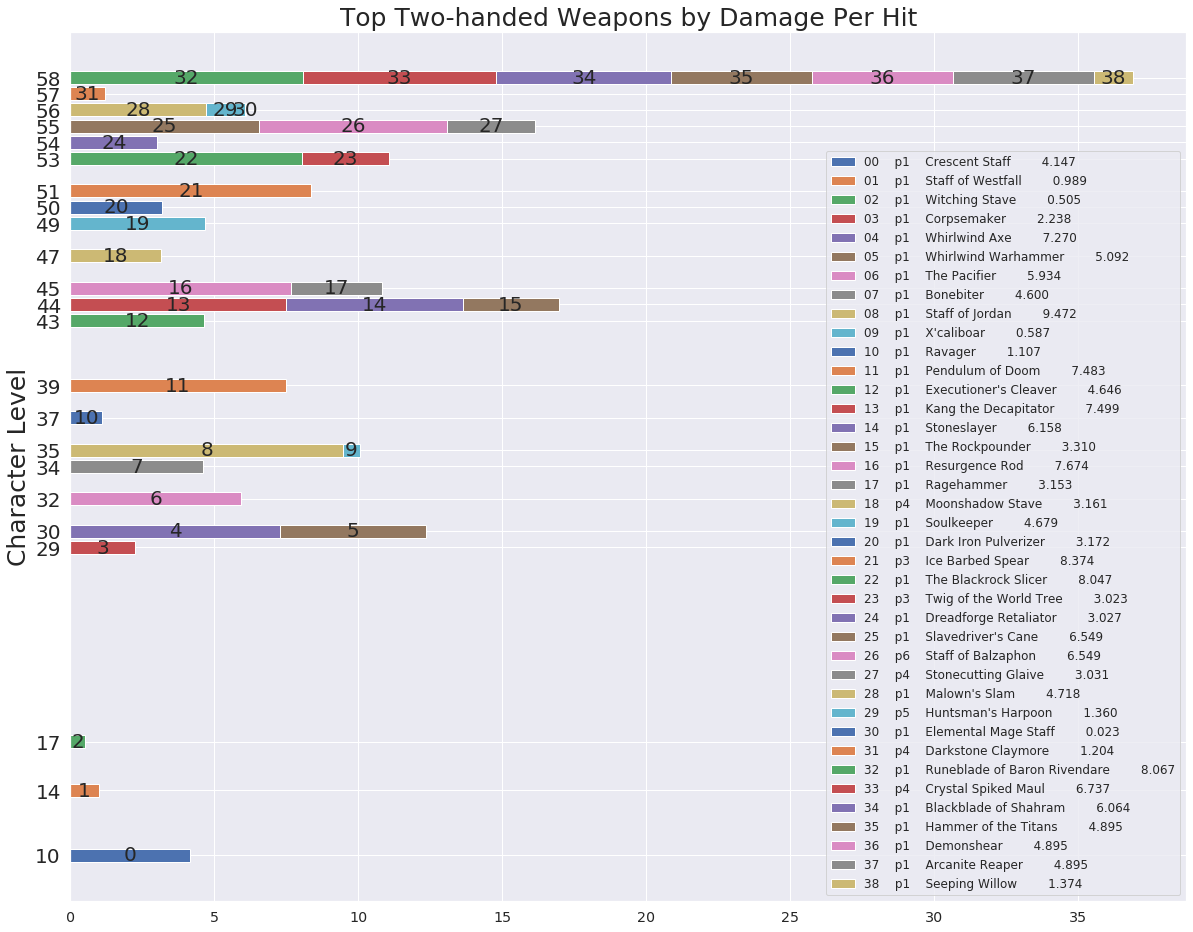

In [16]:
resultByLevelsup = pd.pivot_table(sortedMeleeWeaponData, index = ['reqlevel', 'occur'], values="levelsup")
resultByName = pd.pivot_table(sortedMeleeWeaponData, index = ['reqlevel', 'occur'], 
                              values=["name", "contentPhase"],aggfunc='first')

result = pd.concat([resultByLevelsup, resultByName], axis=1).reset_index()
result.head(100)

reqlevelUnique = len(result['reqlevel'].unique())
qualifiedWeaponNumber = len(result.index)


rows = result['reqlevel']
widths = result['levelsup']
labels = result['name']
phases = result['contentPhase'].astype(int)
row_counts = np.arange(0, qualifiedWeaponNumber)
left = np.zeros(reqlevelUnique,)
idx = np.arange(0,qualifiedWeaponNumber)
pointer = 0
patch_handles = []

for (level, i) in zip(result['reqlevel'], idx):
    if i>0:
        if result['reqlevel'].loc[i]!= result['reqlevel'].loc[i-1]:
            pointer+=1
    idx[i] = pointer


fig, ax = plt.subplots(1, 1, figsize=(20, 16))
for (r, w, l, i, j, p) in zip(rows, widths, labels, idx, row_counts, phases):
    dif = ('%.3f' % w)
    label = (str(j).zfill(2) + '    ' + "p" +  str(p) + '    ' + l + '    '   + '    ' + str(dif))
    patch_handles.append(ax.barh(r, w, align='center', left=left[i], label=label))

    left[i] += w
    patch = patch_handles[-1][0] 
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, "%s" % (j), ha='center',va='center',size = 20)
    
y_pos = result['reqlevel'].unique()
ax.set_yticks(y_pos)
ax.tick_params(axis='y', labelsize=20)
ax.legend(loc = 'best',prop={'size':12})
ax.set_ylabel('Character Level', fontsize=25)
ax.set_title('Top Two-handed Weapons by Damage Per Hit', fontsize=25)

There are 39 weapons that have positive level superior on my leveling path, as shown in the last terms of the legend. I should pay more attention to them!

As for ranged weapons, we only consider the bonus DPS obtained from the attributes Strength, Agility, Attack Power, Critical Strike Chance, Hit Chance.

Text(0.5, 1.0, 'Top Ranged Weapons by Damage Per Second')

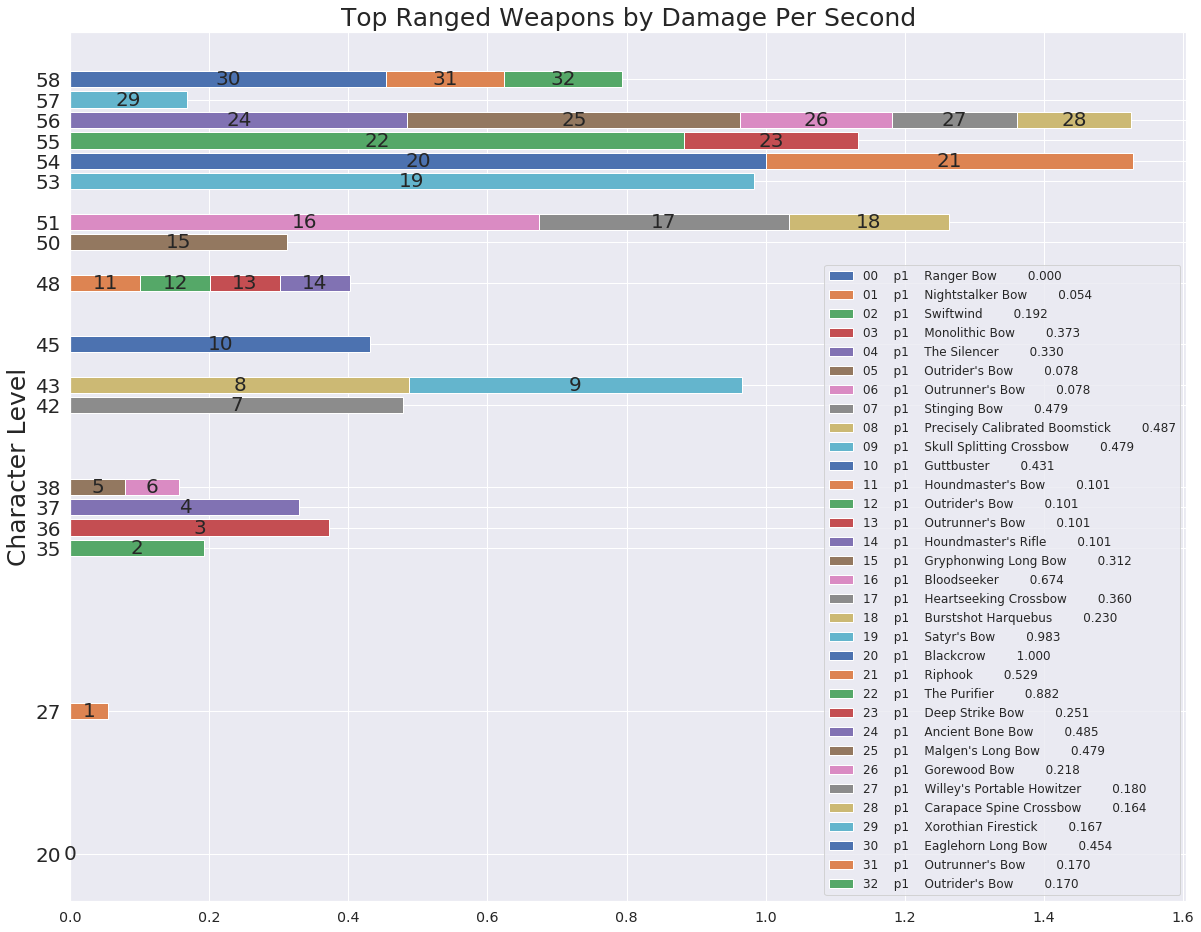

In [17]:
rangedWeaponData = rareWeaponData.query('type== ["2", "18", "3"]')
rangedWeaponData = rangedWeaponData[(rangedWeaponData["str"] + rangedWeaponData["agi"] 
                                     + rangedWeaponData["atkpwr"] + rangedWeaponData["hitpct"] 
                                     + rangedWeaponData["critstrkpct"]!= 0) 
                                    & (rangedWeaponData["reqlevel"] != 60)]

rawDPS = rangedWeaponData["reqlevel"].map(BenchmarkDPS)
bonusDPS = (rangedWeaponData["str"] * 2 / 14 + rangedWeaponData["agi"] / 20 * rawDPS * 0.05 
            + rangedWeaponData["atkpwr"] / 14 + rangedWeaponData["critstrkpct"] * rawDPS * 0.05 
            + rangedWeaponData["hitpct"] * rawDPS * 0.05)
bonusDPS=(bonusDPS-bonusDPS.min())/(bonusDPS.max()-bonusDPS.min())


rangedWeaponData.insert(loc=14, column='bonusDPS', value=bonusDPS)

result = rangedWeaponData.sort_values(['reqlevel', 'bonusDPS'], ascending=[True, False]).reset_index()


reqlevelUnique = len(result['reqlevel'].unique())
qualifiedWeaponNumber = len(result.index)
rows = result['reqlevel']
widths = result['bonusDPS']
labels = result['name']
phases = result['contentPhase'].astype(int)
row_counts = np.arange(0, qualifiedWeaponNumber)
left = np.zeros(reqlevelUnique,)
idx = np.arange(0,qualifiedWeaponNumber)
pointer = 0
patch_handles = []

for (level, i) in zip(result['reqlevel'], idx):
    if i>0:
        if result['reqlevel'].loc[i]!= result['reqlevel'].loc[i-1]:
            pointer+=1
    idx[i] = pointer


fig, ax = plt.subplots(1, 1, figsize=(20, 16))
for (r, w, l, i, j) in zip(rows, widths, labels, idx, row_counts):
    dif = ('%.3f' % w)
    label = (str(j).zfill(2) + '    ' + "p" +  str(p) + '    ' + l + '    '   + '    ' + str(dif))
    patch_handles.append(ax.barh(r, w, align='center', left=left[i], label=label))

    left[i] += w
    patch = patch_handles[-1][0] 
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + bl[0]
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, "%s" % (j), ha='center',va='center',size = 20)
    
y_pos = result['reqlevel'].unique()
ax.set_yticks(y_pos)
ax.tick_params(axis='y', labelsize=20)
ax.legend(loc = 'best',prop={'size':12})
ax.set_ylabel('Character Level', fontsize=25)
ax.set_title('Top Ranged Weapons by Damage Per Second', fontsize=25)

There are 32 ranged weapons can grant me bonus DPS, as shown in the last terms of the legend. 

That's all!